In [1]:
%matplotlib notebook
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import pyro
import matplotlib.pyplot as plt
from datetime import datetime 
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support

In [2]:
print("cargando dataset de entrenamiento...")
mnist_train = datasets.MNIST('/data', train=True, download=True,
                                        transform=transforms.Compose([transforms.ToTensor()]))
print("carga lista")
print("cargando dataset de validacion...")
mnist_valid = datasets.MNIST('/data', train=False, download=True,
                                        transform=transforms.Compose([transforms.ToTensor()]))
print("carga lista")

cargando dataset de entrenamiento...
carga lista
cargando dataset de validacion...
carga lista


C:\Users\vbenj\miniconda3\envs\info320\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
print("total_dataset_train: ",len(mnist_train))
print("seleccionando solamente 4s y 9s...")
_train = [mnist_train[i] for i in range(len(mnist_train)) if mnist_train[i][1] == 4 or mnist_train[i][1] == 9]


print("nuevo dataset train listo")
cant_4 = 0
cant_9 = 0
train_ = []
for t in _train:
    if(t[1] == 4):
        cant_4+=1
        aux = list(t)
        aux[1] = 0
        train_.append(tuple(aux))
    elif(t[1] == 9):
        cant_9+=1
        aux = list(t)
        aux[1] = 1
        train_.append(tuple(aux))

print("total_dataset_train: ",cant_4+cant_9, " = ", len(_train))
print("4: ",cant_4)
print("9: ",cant_9)

total_dataset_train:  60000
seleccionando solamente 4s y 9s...
nuevo dataset train listo
total_dataset_train:  11791  =  11791
4:  5842
9:  5949


In [4]:
print("total_dataset_valid: ",len(mnist_valid))
print("seleccionando solamente 4s y 9s...")
_valid = [mnist_valid[i] for i in range(len(mnist_valid)) if mnist_valid[i][1] == 4 or mnist_valid[i][1] == 9]

print("nuevo dataset valid listo")
cant_4 = 0
cant_9 = 0
valid_ = []
for t in _valid:
    if(t[1] == 4):
        cant_4+=1
        aux = list(t)
        aux[1] = 0
        valid_.append(tuple(aux))
    elif(t[1] == 9):
        cant_9+=1
        aux = list(t)
        aux[1] = 1
        valid_.append(tuple(aux))
print("total_dataset_valid: ",cant_4+cant_9, " = ", len(_valid))
print("4: ",cant_4)
print("9: ",cant_9)

total_dataset_valid:  10000
seleccionando solamente 4s y 9s...
nuevo dataset valid listo
total_dataset_valid:  1991  =  1991
4:  982
9:  1009


In [5]:
# parameters
RANDOM_SEED = 69
LEARNING_RATE_DET = 0.00005
LEARNING_RATE_BAY = 0.00008
BATCH_SIZE_TRAIN = 256
BATCH_SIZE_VALID = 256
N_EPOCHS = 21
DEVICE = 'cpu'
N_SAMPLES_TRAIN = 50
N_SAMPLES_VALID = 50
IMG_SIZE = 28
N_CLASSES = 2

In [6]:
train_loader = DataLoader(train_, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
valid_loader = DataLoader(valid_, batch_size=BATCH_SIZE_VALID, shuffle=True)

# Obtención de accuracy para el modelo Determinístico y Bayesiano

In [7]:
def get_accuracy_det(model, data_loader, device):
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:
            X = X.to(device)
            y_true = y_true.to(device)
            
            n += y_true.size(0)
            
            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)
            correct_pred += (predicted_labels == y_true).sum()
    return correct_pred.float()/ n


In [8]:
def get_accuracy_bay(model, guide, data_loader, n_samples, device):    
    correct_pred = 0
    n = 0
    
    predictive = pyro.infer.Predictive(model, guide=guide, num_samples=n_samples)
    
    for X, y_true in data_loader:
        X = X.to(device)
        y_true = y_true.to(device)
        
        n += y_true.size(0)
        
        acc = predictive(X)
        acc = acc['obs']
        acc = torch.sum(acc, dim=0)
        acc = acc/n_samples
        correct_pred += (np.around(acc) == y_true).sum()
    return correct_pred.float()/n

# Definición de una época de entrenamiento para ambos modelos

In [9]:
def train_det(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:
        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        loss.backward()
        optimizer.step()    
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [10]:
def train_bay(train_loader, model, svi, device):  
    for X, y_true in train_loader:
        X = X.to(device)
        y_true = y_true.to(device)
        
        loss = svi.step(x=X, y=y_true)
    epoch_loss = loss
    return model, svi, epoch_loss

# Definición de una época de validación para ambos modelos

In [11]:
def validate_det(valid_loader, model, criterion, device): 
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
        X = X.to(device)
        y_true = y_true.to(device)

        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)
    epoch_loss = running_loss / len(valid_loader.dataset)      
    return model, epoch_loss

In [12]:
def validate_bay(valid_loader, model, svi, device):
    for X, y_true in valid_loader:
        X = X.to(device)
        y_true = y_true.to(device)
        
        loss = svi.evaluate_loss(x=X, y=y_true)
    epoch_loss = loss
    return model, svi, epoch_loss

# Training loop para ambos modelos

In [13]:
def training_loop_det(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []
    first = True
    
    for epoch in range(0, epochs):
        model, optimizer, train_loss = train_det(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        with torch.no_grad():
            model, valid_loss = validate_det(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy_det(model, train_loader, device=device)
            train_accs.append(train_acc)
            valid_acc = get_accuracy_det(model, valid_loader, device=device)
            valid_accs.append(valid_acc)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')
            plot_losses_det(train_losses, valid_losses, train_accs, valid_accs, first)
            if(first):
                first = False
    
    return model, optimizer, (train_losses, valid_losses)

In [14]:
def training_loop_bay(model, svi, guide, train_loader, valid_loader, n_samples_train, n_samples_valid, epochs, device, print_every=1):
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []
    first = True
    
    for epoch in range(0, epochs):
        model, svi, train_loss = train_bay(train_loader, model, svi, device)
        #train_loss = np.log(train_loss)
        train_losses.append(train_loss)

        model, svi, valid_loss = validate_bay(valid_loader, model, svi, device)
        #valid_loss = np.log(valid_loss)
        valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy_bay(model, guide, train_loader, n_samples_train, device)
            #train_acc = 0
            train_accs.append(train_acc)
            valid_acc = get_accuracy_bay(model, guide, valid_loader, n_samples_valid, device)
            #valid_acc = 0
            valid_accs.append(valid_acc)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')
            plot_losses_bay(train_losses, valid_losses, train_accs, valid_accs, first)
            if(first):
                first = False
    
    return model, svi, guide, (train_losses, valid_losses)

# Calibration plot para el modelo Bayesiano

In [64]:
def plot_calibration_curve(model, guide, data_loader, n_samples, n_bins, device):    
    predictive = pyro.infer.Predictive(model, guide=guide, num_samples=n_samples)

    Y = 0
    for X, y_true in data_loader:
        X = X.to(DEVICE)
        y_true = y_true.to(DEVICE)
        Y = y_true
        acc = predictive(X)
        acc = acc['obs']
        acc = torch.sum(acc, dim=0)
        acc = acc/n_samples

    n_bins = n_bins
    prob_real, prob_pred = calibration_curve(Y, acc, n_bins=n_bins)
    
    print("BINS totales:",len(prob_pred))
    
    perfect_cal = [i/100 for i in range(0,101, 100//(len(prob_pred)-1))]
    
    fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True, dpi=80)
    ax.plot(perfect_cal, perfect_cal, color="red", label='Perfect calibration')
    ax.plot(perfect_cal, prob_pred,color="blue", label='Predicted calibration')
    ax.legend()

# Precission/Recall para ambos modelos

In [24]:
def precission_recall_fscore_det(model, data_loader, device):
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:
            X = X.to(device)
            y_true = y_true.to(device)

            Y = y_true
            _, y_prob = model(X)
            _, acc = torch.max(y_prob, 1)
    precission, recall, fscore, _ =  precision_recall_fscore_support(Y, acc,average='binary')
    return precission, recall, fscore

In [25]:
def precission_recall_fscore_bay(model, guide, data_loader, n_samples, device):
    predictive = pyro.infer.Predictive(model, guide=guide, num_samples=n_samples)
    Y = []
    for X, y_true in data_loader:
        X = X.to(device)
        y_true = y_true.to(device)
        Y = y_true
        acc = predictive(X)
        acc = acc['obs']
        acc = torch.sum(acc, dim=0)
        acc = acc/n_samples
        acc = np.around(acc)
    precission, recall, fscore, _ =  precision_recall_fscore_support(Y, acc,average='binary')
    return precission, recall, fscore

# Obtener curva de calibración y comparación de dos modelos

In [48]:
def get_calibration_comparison(model, model_bay, guide, valid_, valid_loader, n_bins, device):
    data_loader = DataLoader(valid_, batch_size=len(valid_loader.dataset), shuffle=True)
    plot_calibration_curve(model_bay, guide, data_loader, 100, n_bins, device)
    precission_bay, recall_bay, fscore_bay = precission_recall_fscore_bay(model_bay, guide, data_loader, 100, device)
    precission_det, recall_det, fscore_det = precission_recall_fscore_det(model, data_loader, device)


    print(f'Valores para modelo determinista\n'
          f'Precission_det: {precission_det}\t'
          f'Recall_det: {recall_det}\t'
          f'F1_det:{fscore_det}\n')

    print(f'Valores para modelo bayesiano\n'
          f't5Precission_bay: {precission_bay}\t'
          f'Recall_bay: {recall_bay}\t'
          f'F1_bay:{fscore_bay}')

# Modelo determinista

In [15]:
import torch.nn as nn

class Lenet5(nn.Module):
    
    def __init__(self, n_classes=2):
        super(Lenet5, self).__init__()
        
        self.features = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        z = self.features(x)
        z = z.view(z.shape[0], -1)
        logits = self.classifier(z)
        probs = F.softmax(logits, dim=1)
        return logits, probs
    
    
model = Lenet5()
print(model)

Lenet5(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
    (2): Linear(in_features=84, out_features=2, bias=True)
  )
)


# Modelo Bayesiano

In [19]:
from pyro.nn import PyroSample, PyroModule
from pyro.distributions import Normal, Categorical, Bernoulli

class B_Lenet5(PyroModule):
    def __init__(self, n_classes = 2, prior_std = 1.):
        super(B_Lenet5, self).__init__()
        prior = Normal(0, prior_std)
        self.layer1 = PyroModule[torch.nn.Conv2d](1, 6, 5, padding=2)
        self.layer1.weight = PyroSample(prior.expand([6, 1, 5, 5]).to_event(4))
        self.layer1.bias = PyroSample(prior.expand([6]).to_event(1))
        
        self.layer2 = nn.AvgPool2d(kernel_size=2)
        
        self.layer3 = PyroModule[torch.nn.Conv2d](6, 16, 5)
        self.layer3.weight = PyroSample(prior.expand([16, 6, 5, 5]).to_event(4))
        self.layer3.bias = PyroSample(prior.expand([16]).to_event(1))
        
        self.layer4 = nn.AvgPool2d(kernel_size=2)
        
        self.layer5 = PyroModule[torch.nn.Conv2d](16, 120, 5)
        self.layer5.weight = PyroSample(prior.expand([120, 16, 5, 5]).to_event(4))
        self.layer5.bias = PyroSample(prior.expand([120]).to_event(1))
        prior2 = Normal(0, prior_std)
        self.layer6 = PyroModule[torch.nn.Linear](120, 84)
        self.layer6.weight = PyroSample(prior2.expand([84, 120]).to_event(2))
        self.layer6.bias = PyroSample(prior2.expand([84]).to_event(1))
        
        self.layer7 = PyroModule[torch.nn.Linear](84, n_classes)
        self.layer7.weight = PyroSample(prior2.expand([n_classes, 84]).to_event(2))
        self.layer7.bias = PyroSample(prior2.expand([n_classes]).to_event(1))  
        
        self.activation = torch.nn.ReLU()

    def forward(self, x, y=None):
        #print(x.shape)
        h = self.layer1(x)
        h = self.activation(h)
        h = self.layer2(h)
        h = self.activation(self.layer3(h))
        h = self.layer4(h)
        h = self.activation(self.layer5(h))
        h = torch.flatten(h, 1)
        
        h = self.activation(self.layer6(h))
        f = self.layer7(h).squeeze(-1)
        #print(f.shape)
        with pyro.plate("data", size=x.shape[0]):
            logp = pyro.deterministic("logp", f, event_dim=1)
            obs = pyro.sample("obs", Categorical(logits=logp), obs=y) # Multiclass
            #obs = pyro.sample("obs", Bernoulli(logits=logp), obs=y) # Binary
        return obs

model_bay = B_Lenet5()
print(model_bay)

B_Lenet5(
  (layer1): PyroConv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (layer2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (layer3): PyroConv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (layer4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (layer5): PyroConv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (layer6): PyroLinear(in_features=120, out_features=84, bias=True)
  (layer7): PyroLinear(in_features=84, out_features=2, bias=True)
  (activation): ReLU()
)


# Valores a usar para modelo determinista

In [16]:
torch.manual_seed(RANDOM_SEED)

model = Lenet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE_DET)
criterion = nn.CrossEntropyLoss()


### Entrenamiento modelo determinista, visualización de gráficos de loss y accuracy

<IPython.core.display.Javascript object>


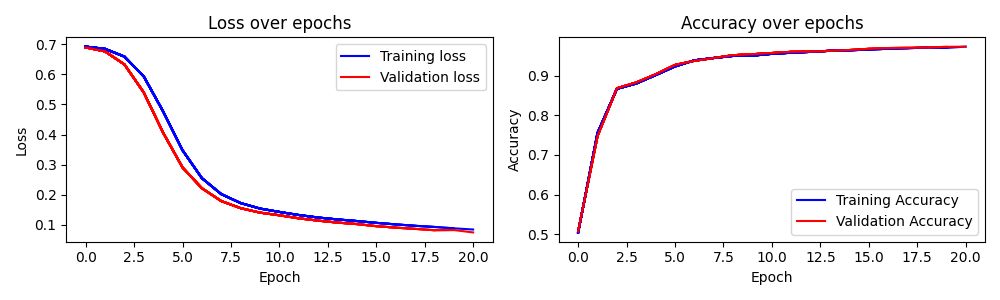

In [17]:
fig, ax = plt.subplots(1,2,figsize=(10, 3), tight_layout=True, dpi=80)
def plot_losses_det(train_losses, valid_losses, train_accs, valid_accs,first):
    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    

    ax[0].plot(train_losses, color='blue', label='Training loss') 
    ax[0].plot(valid_losses, color='red', label='Validation loss')
    ax[0].set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss')
    ax[1].plot(train_accs, color='blue', label='Training Accuracy') 
    ax[1].plot(valid_accs, color='red', label='Validation Accuracy')
    ax[1].set(title="Accuracy over epochs", 
            xlabel='Epoch',
            ylabel='Accuracy') 
    if(first):
        ax[0].legend()
        ax[1].legend()
    fig.canvas.draw()
    
    plt.style.use('default')

In [18]:
model, optimizer, _ = training_loop_det(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)

12:28:36 --- Epoch: 0	Train loss: 0.6915	Valid loss: 0.6888	Train accuracy: 50.45	Valid accuracy: 50.68
12:28:38 --- Epoch: 1	Train loss: 0.6840	Valid loss: 0.6757	Train accuracy: 75.52	Valid accuracy: 74.79
12:28:40 --- Epoch: 2	Train loss: 0.6584	Valid loss: 0.6324	Train accuracy: 86.65	Valid accuracy: 86.79
12:28:41 --- Epoch: 3	Train loss: 0.5925	Valid loss: 0.5394	Train accuracy: 88.01	Valid accuracy: 88.25
12:28:43 --- Epoch: 4	Train loss: 0.4765	Valid loss: 0.4060	Train accuracy: 90.12	Valid accuracy: 90.31
12:28:44 --- Epoch: 5	Train loss: 0.3479	Valid loss: 0.2908	Train accuracy: 92.30	Valid accuracy: 92.67
12:28:46 --- Epoch: 6	Train loss: 0.2553	Valid loss: 0.2218	Train accuracy: 93.83	Valid accuracy: 93.72
12:28:48 --- Epoch: 7	Train loss: 0.2023	Valid loss: 0.1793	Train accuracy: 94.43	Valid accuracy: 94.42
12:28:49 --- Epoch: 8	Train loss: 0.1727	Valid loss: 0.1558	Train accuracy: 94.95	Valid accuracy: 95.13
12:28:51 --- Epoch: 9	Train loss: 0.1545	Valid loss: 0.1410	Trai

# Valores a usar para modelo bayesiano

In [99]:
pyro.set_rng_seed(RANDOM_SEED)
pyro.clear_param_store() 

model_bay = B_Lenet5(prior_std=0.94) 

from pyro.infer.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(model_bay, init_scale=LEARNING_RATE_BAY)


svi = pyro.infer.SVI(model_bay, guide, 
                     optim=pyro.optim.ClippedAdam({'lr':LEARNING_RATE_BAY, 'clip_norm':5}),
                     loss=pyro.infer.TraceMeanField_ELBO()) 

### Entrenamiento modelo bayesiano, visualización de gráficos de loss y accuracy

<IPython.core.display.Javascript object>


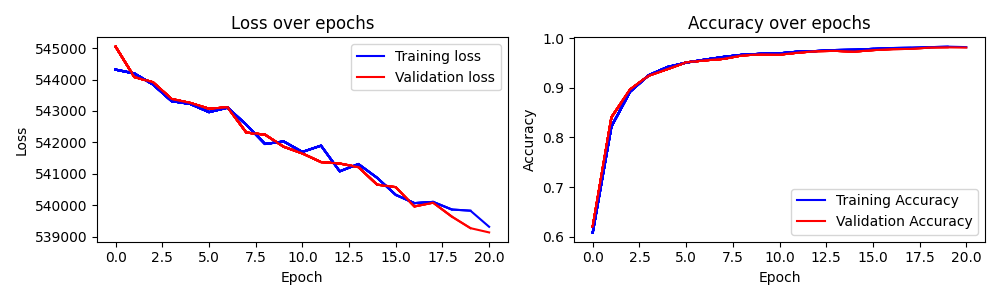

In [100]:
fig, ax = plt.subplots(1,2,figsize=(10, 3), tight_layout=True, dpi=80)
def plot_losses_bay(train_losses, valid_losses, train_accs, valid_accs,first):
    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    
    ax[0].plot(train_losses, color='blue', label='Training loss')
    ax[0].plot(valid_losses, color='red', label='Validation loss')
    ax[0].set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss')
    ax[1].plot(train_accs, color='blue', label='Training Accuracy') 
    ax[1].plot(valid_accs, color='red', label='Validation Accuracy')
    ax[1].set(title="Accuracy over epochs", 
            xlabel='Epoch',
            ylabel='Accuracy') 
    if(first):
        ax[0].legend()
        ax[1].legend()
    fig.canvas.draw()
    
    # change the plot style to default
    plt.style.use('default')

In [101]:
model_bay, svi, guide, _ = training_loop_bay(model_bay, svi, guide, train_loader, valid_loader, N_SAMPLES_TRAIN, N_SAMPLES_VALID, N_EPOCHS, DEVICE)

14:48:43 --- Epoch: 0	Train loss: 544315.2500	Valid loss: 545047.1875	Train accuracy: 60.88	Valid accuracy: 62.08
14:49:13 --- Epoch: 1	Train loss: 544194.1875	Valid loss: 544082.6875	Train accuracy: 82.22	Valid accuracy: 84.08
14:49:43 --- Epoch: 2	Train loss: 543844.8125	Valid loss: 543913.5000	Train accuracy: 89.23	Valid accuracy: 89.65
14:50:15 --- Epoch: 3	Train loss: 543312.8125	Valid loss: 543381.1250	Train accuracy: 92.55	Valid accuracy: 92.47
14:50:44 --- Epoch: 4	Train loss: 543222.8125	Valid loss: 543254.6250	Train accuracy: 94.19	Valid accuracy: 93.77
14:51:16 --- Epoch: 5	Train loss: 542964.1250	Valid loss: 543072.5625	Train accuracy: 95.07	Valid accuracy: 95.13
14:51:48 --- Epoch: 6	Train loss: 543105.1875	Valid loss: 543115.0000	Train accuracy: 95.67	Valid accuracy: 95.53
14:52:19 --- Epoch: 7	Train loss: 542561.2500	Valid loss: 542313.1250	Train accuracy: 96.23	Valid accuracy: 95.83
14:52:50 --- Epoch: 8	Train loss: 541950.6875	Valid loss: 542247.3125	Train accuracy: 96

# Curva de calibración y comparación de los dos modelos

BINS totales: 11


<IPython.core.display.Javascript object>


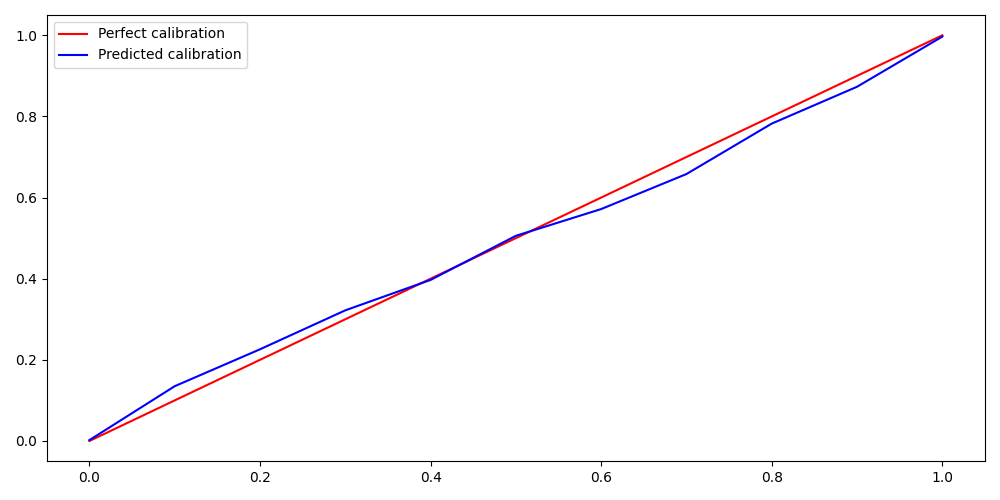

Valores para modelo determinista
Precission_det: 0.9695181907571289	Recall_det: 0.977205153617443	F1_det:0.9733464955577492

Valores para modelo bayesiano
Precission_bay: 0.9898682877406282	Recall_bay: 0.9682854311199207	F1_bay:0.9789579158316634


In [102]:
get_calibration_comparison(model, model_bay, guide, valid_, valid_loader, 11, DEVICE)

Los dos modelos fueron entrenados con learning rate similares (0.00005 el determinista y 0.00008 el bayesiano). Los dos con 21 épocas de entrenamiento. La idea era tener parámetros similares para apreciar la diferencia en los resultados finales.

Se necesitaron sólo 12 épocas en el modelo bayesiano para tener un resultado mejor que el determinista.

Se puede apreciar que el modelo está bastante confiado para ambos números. Para el caso del número 4 (presente en el rango $[0.0-0.5]$), existe la menor confianza del modelo. Para el número 9 (presente en el rango $]0.5,1.0]$) posee una mayor confianza. En general el modelo está muy cerca de la calibración perfecta.

Para los valores de precission, recall y f1score para ambos modelos, podemos apreciar que el modelo bayesiano retorna mejores resultados de precission (acierta mucho más) y de f1score (la relación entre precission y recall).

# Comparación del modelo determinista y bayesiano, variando diferentes valores de prior_std e init_scale

Se dejará el valor de learnig_rate del Adam fijo en 0.0005 para todos los modelos. El valor de prior será 30 (alto) y 0.5 (bajo). El valor de init será 2.5 (alto) y 0.00001 (bajo)

## Prior alto, init bajo

In [85]:
pyro.set_rng_seed(RANDOM_SEED)
pyro.clear_param_store() 

model_bay = B_Lenet5(prior_std=30) 

from pyro.infer.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(model_bay, init_scale=0.00001)


svi = pyro.infer.SVI(model_bay, guide, 
                     optim=pyro.optim.ClippedAdam({'lr':0.0005, 'clip_norm':5}),
                     loss=pyro.infer.TraceMeanField_ELBO()) 

<IPython.core.display.Javascript object>


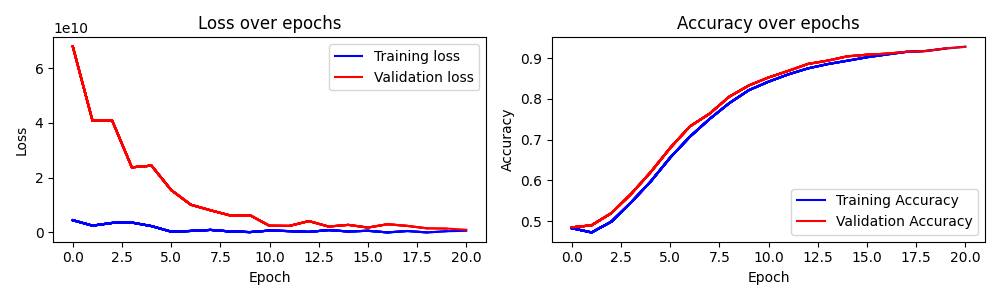

In [86]:
fig, ax = plt.subplots(1,2,figsize=(10, 3), tight_layout=True, dpi=80)
def plot_losses_bay(train_losses, valid_losses, train_accs, valid_accs,first):
    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    
    ax[0].plot(train_losses, color='blue', label='Training loss')
    ax[0].plot(valid_losses, color='red', label='Validation loss')
    ax[0].set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss')
    ax[1].plot(train_accs, color='blue', label='Training Accuracy') 
    ax[1].plot(valid_accs, color='red', label='Validation Accuracy')
    ax[1].set(title="Accuracy over epochs", 
            xlabel='Epoch',
            ylabel='Accuracy') 
    if(first):
        ax[0].legend()
        ax[1].legend()
    fig.canvas.draw()
    
    # change the plot style to default
    plt.style.use('default')

In [87]:
model_bay, svi, guide, _ = training_loop_bay(model_bay, svi, guide, train_loader, valid_loader, N_SAMPLES_TRAIN, N_SAMPLES_VALID, N_EPOCHS, DEVICE)

13:58:38 --- Epoch: 0	Train loss: 4460540416.0000	Valid loss: 67824488448.0000	Train accuracy: 48.26	Valid accuracy: 48.47
13:59:08 --- Epoch: 1	Train loss: 2479585792.0000	Valid loss: 40803688448.0000	Train accuracy: 47.22	Valid accuracy: 48.97
13:59:39 --- Epoch: 2	Train loss: 3467200768.0000	Valid loss: 40828645376.0000	Train accuracy: 49.83	Valid accuracy: 51.93
14:00:09 --- Epoch: 3	Train loss: 3605752064.0000	Valid loss: 23764107264.0000	Train accuracy: 54.55	Valid accuracy: 56.60
14:00:40 --- Epoch: 4	Train loss: 2309391616.0000	Valid loss: 24378138624.0000	Train accuracy: 59.68	Valid accuracy: 61.98
14:01:10 --- Epoch: 5	Train loss: 286206240.0000	Valid loss: 15464825856.0000	Train accuracy: 65.58	Valid accuracy: 67.96
14:01:41 --- Epoch: 6	Train loss: 541432000.0000	Valid loss: 10107889664.0000	Train accuracy: 70.71	Valid accuracy: 73.23
14:02:11 --- Epoch: 7	Train loss: 922141696.0000	Valid loss: 8082343424.0000	Train accuracy: 75.05	Valid accuracy: 76.34
14:02:40 --- Epoch: 

BINS totales: 2


<IPython.core.display.Javascript object>


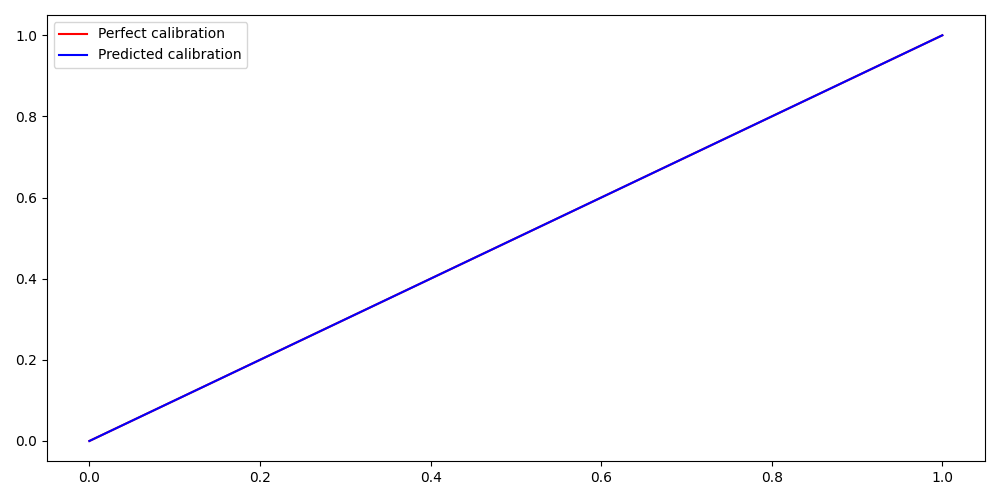

Valores para modelo determinista
Precission_det: 0.9695181907571289	Recall_det: 0.977205153617443	F1_det:0.9733464955577492

Valores para modelo bayesiano
Precission_bay: 0.9302788844621513	Recall_bay: 0.9256689791873142	F1_bay:0.9279682066567312


In [88]:
get_calibration_comparison(model, model_bay, guide, valid_, valid_loader, 11,DEVICE)

Los resultados de accuracy son buenos (no mejores que el modelo determinista). Dentro del gráfico de calibración, el modelo solo presenta 2 bins, esto significa que de las 100 muestras que se usaron para determinar su probabilidad de elección, seleccionaba en las 100 o 1 o 0 (lo que resulta en dos resultados promedios los cuales son 1 y 0, lo que conlleva a los 2 bines). Vemos que con la accuracy aún teniendo confianza en decir solamente 1 y solamente 0, no acierta tanto.

El entrenamiento convergió rápido y la curva de accuracy se ve estable y creciente con respecto a la cantidad de épocas que pasan, lo que indicaría que el modelo pudo tener un mejor resultado a medida que pasaran más épocas.

## Prior bajo e init alto

In [81]:
pyro.set_rng_seed(RANDOM_SEED)
pyro.clear_param_store() 

model_bay = B_Lenet5(prior_std=0.5) 

from pyro.infer.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(model_bay, init_scale=2.5)


svi = pyro.infer.SVI(model_bay, guide, 
                     optim=pyro.optim.ClippedAdam({'lr':0.0005, 'clip_norm':5}),
                     loss=pyro.infer.TraceMeanField_ELBO()) 

<IPython.core.display.Javascript object>


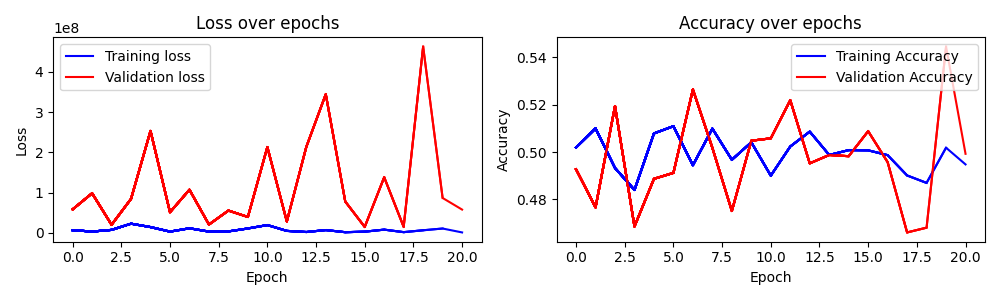

In [82]:
fig, ax = plt.subplots(1,2,figsize=(10, 3), tight_layout=True, dpi=80)
def plot_losses_bay(train_losses, valid_losses, train_accs, valid_accs,first):
    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    
    ax[0].plot(train_losses, color='blue', label='Training loss')
    ax[0].plot(valid_losses, color='red', label='Validation loss')
    ax[0].set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss')
    ax[1].plot(train_accs, color='blue', label='Training Accuracy') 
    ax[1].plot(valid_accs, color='red', label='Validation Accuracy')
    ax[1].set(title="Accuracy over epochs", 
            xlabel='Epoch',
            ylabel='Accuracy') 
    if(first):
        ax[0].legend()
        ax[1].legend()
    fig.canvas.draw()
    
    # change the plot style to default
    plt.style.use('default')

In [83]:
model_bay, svi, guide, _ = training_loop_bay(model_bay, svi, guide, train_loader, valid_loader, N_SAMPLES_TRAIN, N_SAMPLES_VALID, N_EPOCHS, DEVICE)

13:48:17 --- Epoch: 0	Train loss: 6500126.5000	Valid loss: 58157788.0000	Train accuracy: 50.19	Valid accuracy: 49.27
13:48:46 --- Epoch: 1	Train loss: 2995820.2500	Valid loss: 98207776.0000	Train accuracy: 51.00	Valid accuracy: 47.66
13:49:16 --- Epoch: 2	Train loss: 7174108.0000	Valid loss: 19888466.0000	Train accuracy: 49.33	Valid accuracy: 51.93
13:49:46 --- Epoch: 3	Train loss: 22573902.0000	Valid loss: 84307016.0000	Train accuracy: 48.40	Valid accuracy: 46.86
13:50:16 --- Epoch: 4	Train loss: 14155686.0000	Valid loss: 253230432.0000	Train accuracy: 50.78	Valid accuracy: 48.87
13:50:46 --- Epoch: 5	Train loss: 2873809.5000	Valid loss: 51102724.0000	Train accuracy: 51.09	Valid accuracy: 49.12
13:51:15 --- Epoch: 6	Train loss: 11150764.0000	Valid loss: 107065664.0000	Train accuracy: 49.44	Valid accuracy: 52.64
13:51:45 --- Epoch: 7	Train loss: 2923018.5000	Valid loss: 20452436.0000	Train accuracy: 50.99	Valid accuracy: 50.18
13:52:17 --- Epoch: 8	Train loss: 3376127.5000	Valid loss: 

BINS totales: 3


<IPython.core.display.Javascript object>


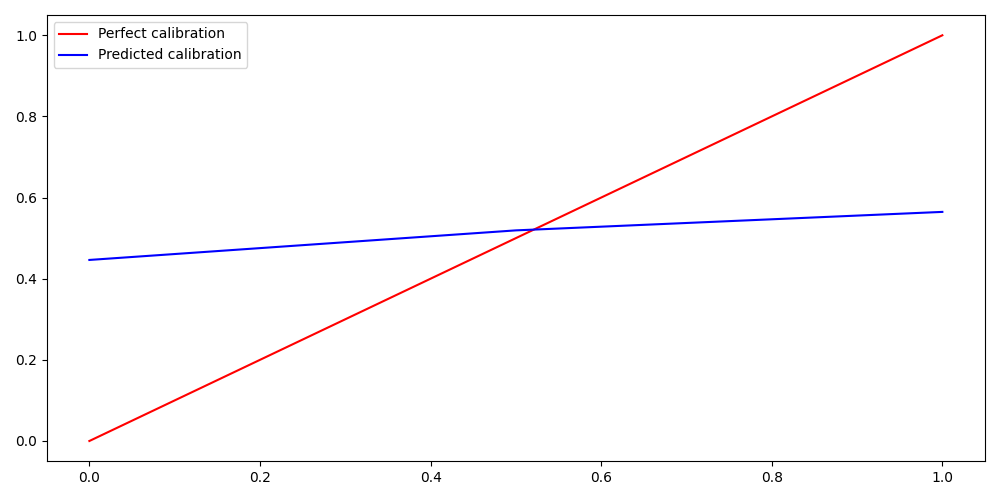

Valores para modelo determinista
Precission_det: 0.9695181907571289	Recall_det: 0.977205153617443	F1_det:0.9733464955577492

Valores para modelo bayesiano
Precission_bay: 0.6540880503144654	Recall_bay: 0.20614469772051536	F1_bay:0.31348907309721175


In [84]:
get_calibration_comparison(model, model_bay, guide, valid_, valid_loader, 11,DEVICE)

Los resultados son bastante malos, la precisión en las pruebas fue de 65% y solo presenta 3 bines (0, .5 y 1). Podemos ver que que la curva de acc de entrenamiento es bastante inestable. Para este set de prueba es mala idea ocupar prior pequeño e init alto. 

Las curvas de entrenamientos son bastante malas, y no entregan una información de que tan bien está nuestro modelo.

## Prior e init altos

In [89]:
pyro.set_rng_seed(RANDOM_SEED)
pyro.clear_param_store() 

model_bay = B_Lenet5(prior_std=30) 

from pyro.infer.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(model_bay, init_scale=2.5)


svi = pyro.infer.SVI(model_bay, guide, 
                     optim=pyro.optim.ClippedAdam({'lr':0.0005, 'clip_norm':5}),
                     loss=pyro.infer.TraceMeanField_ELBO()) 

<IPython.core.display.Javascript object>


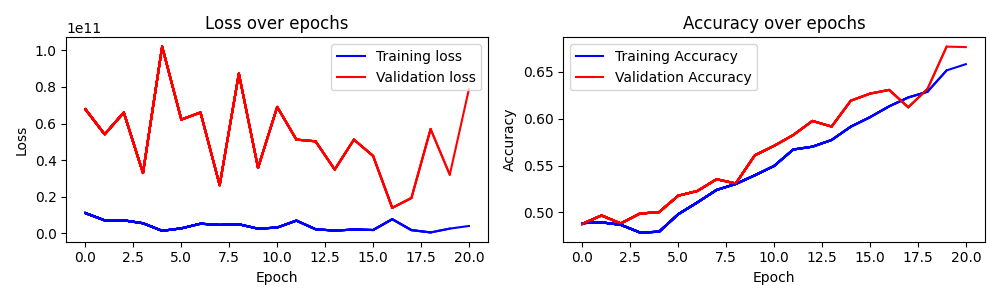

In [90]:
fig, ax = plt.subplots(1,2,figsize=(10, 3), tight_layout=True, dpi=80)
def plot_losses_bay(train_losses, valid_losses, train_accs, valid_accs,first):
    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    
    ax[0].plot(train_losses, color='blue', label='Training loss')
    ax[0].plot(valid_losses, color='red', label='Validation loss')
    ax[0].set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss')
    ax[1].plot(train_accs, color='blue', label='Training Accuracy') 
    ax[1].plot(valid_accs, color='red', label='Validation Accuracy')
    ax[1].set(title="Accuracy over epochs", 
            xlabel='Epoch',
            ylabel='Accuracy') 
    if(first):
        ax[0].legend()
        ax[1].legend()
    fig.canvas.draw()
    
    # change the plot style to default
    plt.style.use('default')

In [91]:
model_bay, svi, guide, _ = training_loop_bay(model_bay, svi, guide, train_loader, valid_loader, N_SAMPLES_TRAIN, N_SAMPLES_VALID, N_EPOCHS, DEVICE)

14:24:29 --- Epoch: 0	Train loss: 11112778752.0000	Valid loss: 67758948352.0000	Train accuracy: 48.85	Valid accuracy: 48.77
14:24:57 --- Epoch: 1	Train loss: 7178266624.0000	Valid loss: 54101852160.0000	Train accuracy: 48.94	Valid accuracy: 49.67
14:25:25 --- Epoch: 2	Train loss: 7174150656.0000	Valid loss: 66014969856.0000	Train accuracy: 48.67	Valid accuracy: 48.82
14:25:52 --- Epoch: 3	Train loss: 5596387840.0000	Valid loss: 32985499648.0000	Train accuracy: 47.86	Valid accuracy: 49.87
14:26:20 --- Epoch: 4	Train loss: 1463140352.0000	Valid loss: 101944434688.0000	Train accuracy: 47.93	Valid accuracy: 50.03
14:26:47 --- Epoch: 5	Train loss: 2811028480.0000	Valid loss: 62147297280.0000	Train accuracy: 49.80	Valid accuracy: 51.78
14:27:15 --- Epoch: 6	Train loss: 5342757888.0000	Valid loss: 66020679680.0000	Train accuracy: 51.06	Valid accuracy: 52.29
14:27:43 --- Epoch: 7	Train loss: 4674334720.0000	Valid loss: 26334590976.0000	Train accuracy: 52.40	Valid accuracy: 53.54
14:28:10 --- E

BINS totales: 10


<IPython.core.display.Javascript object>


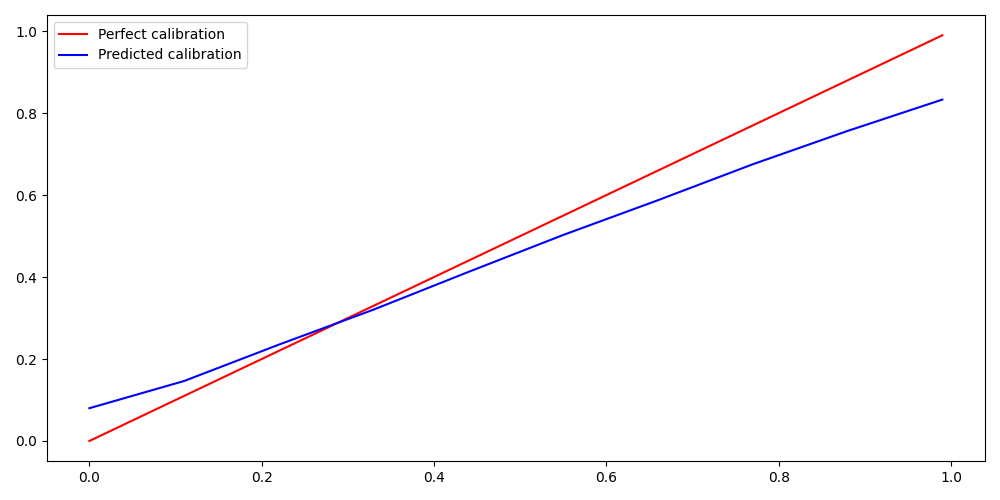

Valores para modelo determinista
Precission_det: 0.9695181907571289	Recall_det: 0.977205153617443	F1_det:0.9733464955577492

Valores para modelo bayesiano
Precission_bay: 0.6723618090452261	Recall_bay: 0.6630327056491576	F1_bay:0.6676646706586826


In [92]:
get_calibration_comparison(model, model_bay, guide, valid_, valid_loader, 11,DEVICE)

Los resultados son malos, pero mejor que usando el prior bajo. En general la confianza de las respuestas es buena para ambos números, lo malo es que se equivoca al elegir. Podemos decir que si se quiere ocupar un init alto se debe ocupar un prior alto igual, pero con la primera prueba demostramos que el resultado es mejor (ocupando un prior alto) teniendo un init bajo. Por lo que teniendo menos prior mejores resultados obtendremos.

La curva de entrenamiento de accuracy, aunque va subiendo, presenta resultados bastante malos.

## Prior e init bajos

In [93]:
pyro.set_rng_seed(RANDOM_SEED)
pyro.clear_param_store() 

model_bay = B_Lenet5(prior_std=0.5) 

from pyro.infer.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(model_bay, init_scale=0.00001)


svi = pyro.infer.SVI(model_bay, guide, 
                     optim=pyro.optim.ClippedAdam({'lr':0.0005, 'clip_norm':5}),
                     loss=pyro.infer.TraceMeanField_ELBO()) 

<IPython.core.display.Javascript object>


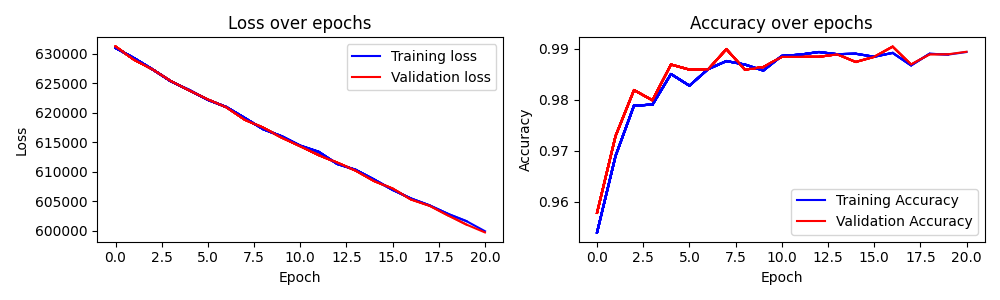

In [94]:
fig, ax = plt.subplots(1,2,figsize=(10, 3), tight_layout=True, dpi=80)
def plot_losses_bay(train_losses, valid_losses, train_accs, valid_accs,first):
    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    
    ax[0].plot(train_losses, color='blue', label='Training loss')
    ax[0].plot(valid_losses, color='red', label='Validation loss')
    ax[0].set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss')
    ax[1].plot(train_accs, color='blue', label='Training Accuracy') 
    ax[1].plot(valid_accs, color='red', label='Validation Accuracy')
    ax[1].set(title="Accuracy over epochs", 
            xlabel='Epoch',
            ylabel='Accuracy') 
    if(first):
        ax[0].legend()
        ax[1].legend()
    fig.canvas.draw()
    
    # change the plot style to default
    plt.style.use('default')

In [95]:
model_bay, svi, guide, _ = training_loop_bay(model_bay, svi, guide, train_loader, valid_loader, N_SAMPLES_TRAIN, N_SAMPLES_VALID, N_EPOCHS, DEVICE)

14:36:37 --- Epoch: 0	Train loss: 630953.0000	Valid loss: 631165.3125	Train accuracy: 95.39	Valid accuracy: 95.78
14:37:05 --- Epoch: 1	Train loss: 629225.3750	Valid loss: 628972.5625	Train accuracy: 96.90	Valid accuracy: 97.29
14:37:32 --- Epoch: 2	Train loss: 627329.0000	Valid loss: 627325.8125	Train accuracy: 97.89	Valid accuracy: 98.19
14:38:00 --- Epoch: 3	Train loss: 625289.2500	Valid loss: 625316.9375	Train accuracy: 97.91	Valid accuracy: 97.99
14:38:27 --- Epoch: 4	Train loss: 623802.6875	Valid loss: 623768.3750	Train accuracy: 98.51	Valid accuracy: 98.69
14:38:56 --- Epoch: 5	Train loss: 622158.1875	Valid loss: 622209.1250	Train accuracy: 98.28	Valid accuracy: 98.59
14:39:26 --- Epoch: 6	Train loss: 620952.7500	Valid loss: 620920.3125	Train accuracy: 98.60	Valid accuracy: 98.59
14:39:55 --- Epoch: 7	Train loss: 619091.7500	Valid loss: 618810.8125	Train accuracy: 98.76	Valid accuracy: 99.00
14:40:25 --- Epoch: 8	Train loss: 617191.7500	Valid loss: 617436.3125	Train accuracy: 98

BINS totales: 11


<IPython.core.display.Javascript object>


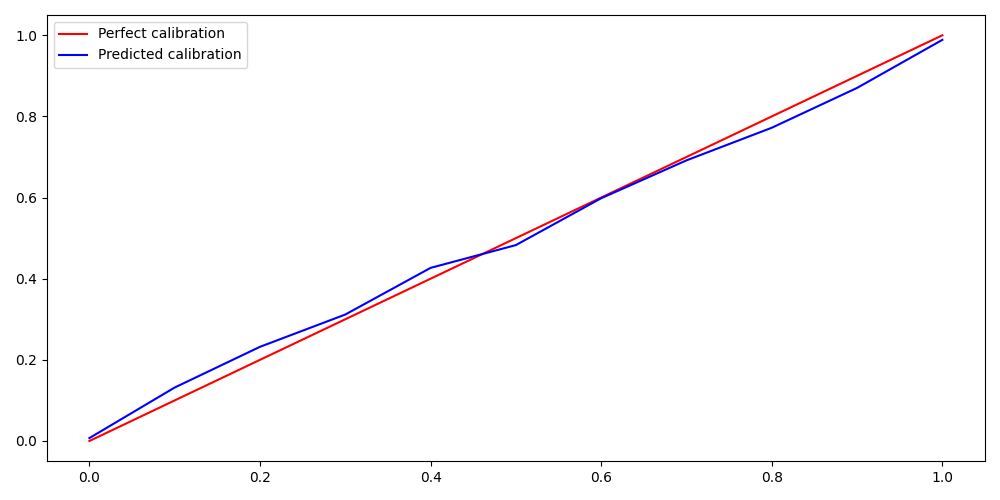

Valores para modelo determinista
Precission_det: 0.9695181907571289	Recall_det: 0.977205153617443	F1_det:0.9733464955577492

Valores para modelo bayesiano
Precission_bay: 0.9910536779324056	Recall_bay: 0.9881070366699702	F1_bay:0.9895781637717123


In [98]:
get_calibration_comparison(model, model_bay, guide, valid_, valid_loader, 11,DEVICE)

Los resultados obtenidos son mejor que con el modelo creado inicialmente. Vimos con la prueba anterior y con la primera que lo mejor para usar un init bajo, es un prior bajo. En este caso bajamos los paramentros aún más que los usados en el modelo principal y los resultados fueron mucho mejores desde un inicio.

Existe una confianza casi perfecta y los resultados de accuracy, recall y F1 son mucho mayores que el modelo determinista.

La curva de accuracy frente a épocas es un poco ruidosa y el loss no converge pero los resultados muy buenos.

Con esto dicho, se puede definir que para este modelo de Lenet5, al querer usarlo de manera bayesiana, debemos ocupar prior e init bajos para lograr resultados muy buenos.

En general se puede decir que el usar redes neuronales bayesianas (aún siendo más difíciles de encontrar buenos parámetros, ya que necesitas cambiar más variables) presentan mejores resultado. Además al ser algo probabilístico, abre nuevas posibilidades a las respuestas de la red, como por ejemplo: podemos escoger si dar un resultado o no, dependiendo de que tan seguro está nuestra red de un resultado (viendo la probabilidad de la respuesta), mientras que la red determinista va a entregar si o sí un resultado. 